<a href="https://colab.research.google.com/github/a-mhamdi/jlai/blob/main/Codes/Julia/Part-3/cnn/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HANDWRITTEN DIGITS RECOGNITION USING CNN
---

Handwritten digits classification using **CNN**. This solution is implemented in `Julia` using the `Flux.jl` library

In [ ]:
versioninfo() # -> v"1.11.2"

Julia Version 1.11.2
Commit 5e9a32e7af2 (2024-12-01 20:02 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 8 × Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, skylake)
Threads: 1 default, 0 interactive, 1 GC (on 8 virtual cores)
Environment:
  LD_LIBRARY_PATH = /home/mhamdi/torch/install/lib:/home/mhamdi/torch/install/lib:/home/mhamdi/torch/install/lib:
  DYLD_LIBRARY_PATH = /home/mhamdi/torch/install/lib:/home/mhamdi/torch/install/lib:/home/mhamdi/torch/install/lib:
  JULIA_NUM_THREADS = 8


In [ ]:
using Pkg; pkg"activate ."; pkg"status"

  Activating project at `~/Work/git-repos/AI-ML-DL/jlai/Codes/Julia/Part-3/cnn`


Status `~/Work/git-repos/AI-ML-DL/jlai/Codes/Julia/Part-3/cnn/Project.toml`
  [fbb218c0] BSON v0.3.9
  [587475ba] Flux v0.16.0
⌃ [82e4d734] ImageIO v0.6.8
  [d8c32880] ImageInTerminal v0.5.4
  [4e3cecfd] ImageShow v0.3.8
  [86fae568] ImageView v0.12.6
  [916415d5] Images v0.26.1
  [eb30cadb] MLDatasets v0.7.18
  [91a5bcdd] Plots v1.40.9
  [c3e4b0f8] Pluto v0.20.4
  [7f904dfe] PlutoUI v0.7.60
  [92933f4c] ProgressMeter v1.10.2
  [10745b16] Statistics v1.11.1
  [d6f4376e] Markdown v1.11.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [ ]:
using CUDA

In [ ]:
using Statistics
using ProgressMeter: Progress, next!
using Plots

Import the machine learning library `Flux`

In [ ]:
using Flux # v"0.16.0"
using Flux: DataLoader
using Flux: onecold, onehotbatch

In [ ]:
using MLDatasets
d = MNIST()

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

In [ ]:
Base.@kwdef mutable struct HyperParams
    η = 3f-3                # Learning rate
    batchsize = 64          # Batch size
    epochs = 8              # Number of epochs
    split = :train          # Split data into `train` and `test`
end

HyperParams

Load the **MNIST** dataset

In [ ]:
function get_data(; kws...)
    args = HyperParams(; kws...);
    # Split and normalize data
    data = MNIST(split=args.split);
    X, y = data.features ./ 255, data.targets;
    X = reshape(X, (28, 28, 1, :));
    y = onehotbatch(y, 0:9);
    loader = DataLoader((X, y); batchsize=args.batchsize, shuffle=true);
    return loader
end

get_data (generic function with 1 method)

In [ ]:
train_loader = get_data();
test_loader = get_data(split=:test);

Transform sample training data to an image. View the image and check the corresponding digit value.

In [ ]:
idx = rand(1:6_000);

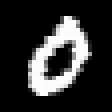

In [ ]:
using ImageShow, ImageInTerminal # ImageView
convert2image(d, idx) # |> imshow

In [ ]:
print("Digit is $(d.targets[idx])")

Digit is 0

**CNN** ARCHITECTURE

The input `X` is a batch of images with dimensions `(width=28, height=28, channels=1, batchsize)`

In [ ]:
fc = prod(Int.(floor.([28/4 - 2, 28/4 - 2, 16]))) # 2^{\# max-pool}

400

In [ ]:
model = Chain(
            Conv((5, 5), 1 => 16, relu),  # (28-5+1)x(28-5+1)x16 = 24x24x16
            MaxPool((2, 2)),              # 12x12x16
            Conv((3, 3), 16 => 16, relu), # (12-3+1)x(12-3+1)x16 = 10x10x16
            MaxPool((2, 2)),              # 5x5x16
            Flux.flatten,                 # 400
            Dense(fc => 64, relu),
            Dense(64 => 32, relu),
            Dense(32 => 10)
)

Chain(
  Conv((5, 5), 1 => 16, relu),          # 416 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 16 => 16, relu),         # 2_320 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(400 => 64, relu),               # 25_664 parameters
  Dense(64 => 32, relu),                # 2_080 parameters
  Dense(32 => 10),                      # 330 parameters
)                   # Total: 10 arrays, 30_810 parameters, 121.156 KiB.

In [ ]:
function train(; kws...)
    args = HyperParams(; kws...)
    # Define the loss function
    l(α, β) = Flux.logitcrossentropy(α, β)
    # Define the accuracy metric
    acc(α, β) = mean(onecold(α) .== onecold(β))
    # Optimizer
    optim_state = Flux.setup(Adam(args.η), model);

    vec_loss = []
    vec_acc = []

    for epoch in 1:args.epochs
        printstyled("\t***\t === EPOCH $(epoch) === \t*** \n", color=:magenta, bold=true)
        @info "TRAINING"
        prg_train = Progress(length(train_loader))
        for (X, y) in train_loader
            loss, grads = Flux.withgradient(model) do m
                ŷ = m(X);
                l(ŷ, y);
            end
            Flux.update!(optim_state, model, grads[1]); # Upd `W` and `b`
            # Show progress meter
            next!(prg_train, showvalues=[(:loss, loss)])
        end
        @info "TESTING"
        prg_test = Progress(length(test_loader))
        for (X, y) in test_loader
            ŷ = model(X);
            push!(vec_loss, l(ŷ, y));  # log `loss` value -> `vec_loss` vector
            push!(vec_acc, acc(ŷ, y)); # log `accuracy` value -> `vec_acc` vector
          	# Show progress meter
            next!(prg_test, showvalues=[(:loss, vec_loss[end]), (:accuracy, vec_acc[end])])
        end
    end
    return vec_loss, vec_acc
end

train (generic function with 1 method)

In [ ]:
vec_loss, vec_acc = train()

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/kVZZH/src/ProgressMeter.jl:594
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  loss:      2.2790155
  accuracy:  0.3125


(Any[2.3015609f0, 2.3082972f0, 2.2953932f0, 2.2969155f0, 2.2981534f0, 2.3026373f0, 2.288465f0, 2.3023608f0, 2.3002977f0, 2.3011193f0  …  2.2893078f0, 2.3139884f0, 2.3012142f0, 2.297553f0, 2.2960894f0, 2.306082f0, 2.2939084f0, 2.2967253f0, 2.2960145f0, 2.2790155f0], Any[0.09375, 0.078125, 0.125, 0.125, 0.15625, 0.125, 0.203125, 0.125, 0.109375, 0.125  …  0.15625, 0.078125, 0.109375, 0.140625, 0.140625, 0.109375, 0.171875, 0.109375, 0.21875, 0.3125])

Plot results

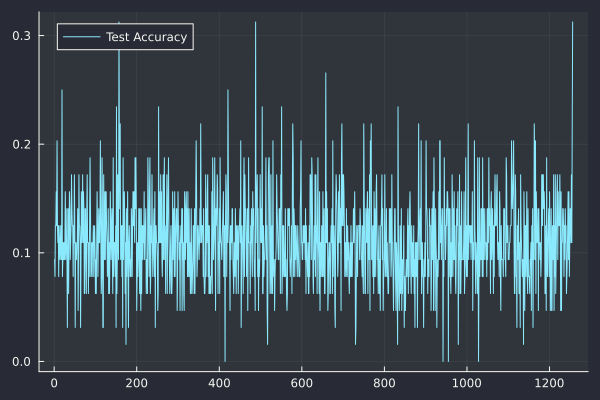

In [ ]:
plot(vec_loss, label="Test Loss")
plot(vec_acc, label="Test Accuracy")

Let's make some predictions

In [ ]:
idx = rand(1:1000, 16)
xs, ys = test_loader.data[1][:,:,:,idx], onecold(test_loader.data[2][:, idx]) .- 1
yp = onecold(model(xs)) .- 1;

In [ ]:
for i ∈ eachindex(yp)
    @info "**Prediction is $(yp[i]). Label is $(ys[i]).**"
end

[ Info: **Prediction is 1. Label is 1.**
[ Info: **Prediction is 1. Label is 1.**
[ Info: **Prediction is 1. Label is 2.**
[ Info: **Prediction is 1. Label is 3.**
[ Info: **Prediction is 1. Label is 6.**
[ Info: **Prediction is 1. Label is 9.**
[ Info: **Prediction is 1. Label is 0.**
[ Info: **Prediction is 1. Label is 4.**
[ Info: **Prediction is 1. Label is 9.**
[ Info: **Prediction is 1. Label is 8.**
[ Info: **Prediction is 1. Label is 6.**
[ Info: **Prediction is 1. Label is 1.**
[ Info: **Prediction is 1. Label is 1.**
[ Info: **Prediction is 1. Label is 6.**
[ Info: **Prediction is 1. Label is 4.**
[ Info: **Prediction is 1. Label is 4.**


Save the model

In [ ]:
using BSON: @save
@save "cnn.bson" model